# 16d: Interaction Network Visualization

**Goal**: Create a graph visualization of domino interactions where edges represent synergy strength.

**Method**: Use networkx to create a network graph with:
- Nodes: 28 dominoes
- Edges: Synergy between pairs (from 16c)
- Edge thickness/color: Synergy magnitude and direction

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pathlib import Path

from forge.analysis.utils import viz
from forge.oracle import schema

viz.setup_notebook_style()
plt.rcParams['font.size'] = 10
print("Ready")

Ready


## 1. Load Data

In [2]:
# Load interaction matrix and pair synergies from 16c
synergy_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/16c_pair_synergies.csv"
single_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/16c_single_effects.csv"

synergy_df = pd.read_csv(synergy_path)
single_df = pd.read_csv(single_path)

print(f"Loaded {len(synergy_df)} pairs")
print(f"Synergy range: [{synergy_df['synergy'].min():.2f}, {synergy_df['synergy'].max():.2f}]")
print(f"\nSingle effects range: [{single_df['effect'].min():.2f}, {single_df['effect'].max():.2f}]")

Loaded 378 pairs
Synergy range: [-11.86, 14.61]

Single effects range: [-9.55, 8.21]


In [3]:
# Create domino name lookup
def domino_name(d_id: int) -> str:
    pips = schema.domino_pips(d_id)
    return f"{pips[0]}-{pips[1]}"

DOMINO_NAMES = [domino_name(d) for d in range(28)]

# Create is_double lookup
def is_double(d_id: int) -> bool:
    pips = schema.domino_pips(d_id)
    return pips[0] == pips[1]

DOUBLES = [d for d in range(28) if is_double(d)]

## 2. Build Network Graph

In [4]:
# Create graph
G = nx.Graph()

# Create domino name to effect lookup from single_df
single_effect_lookup = dict(zip(single_df['domino'], single_df['effect']))

# Add all 28 dominoes as nodes
for d in range(28):
    name = DOMINO_NAMES[d]
    single_effect = single_effect_lookup.get(name, 0)
    G.add_node(name, d_id=d, is_double=is_double(d), single_effect=single_effect)

# Add edges for significant synergies (threshold: |synergy| > 5)
SYNERGY_THRESHOLD = 5.0

for _, row in synergy_df.iterrows():
    d1_name = DOMINO_NAMES[int(row['d1'])]
    d2_name = DOMINO_NAMES[int(row['d2'])]
    synergy = row['synergy']
    
    if abs(synergy) > SYNERGY_THRESHOLD:
        G.add_edge(d1_name, d2_name, synergy=synergy, weight=abs(synergy))

print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges (|synergy| > {SYNERGY_THRESHOLD}): {G.number_of_edges()}")

Nodes: 28
Edges (|synergy| > 5.0): 87


## 3. Network Visualization - Spring Layout

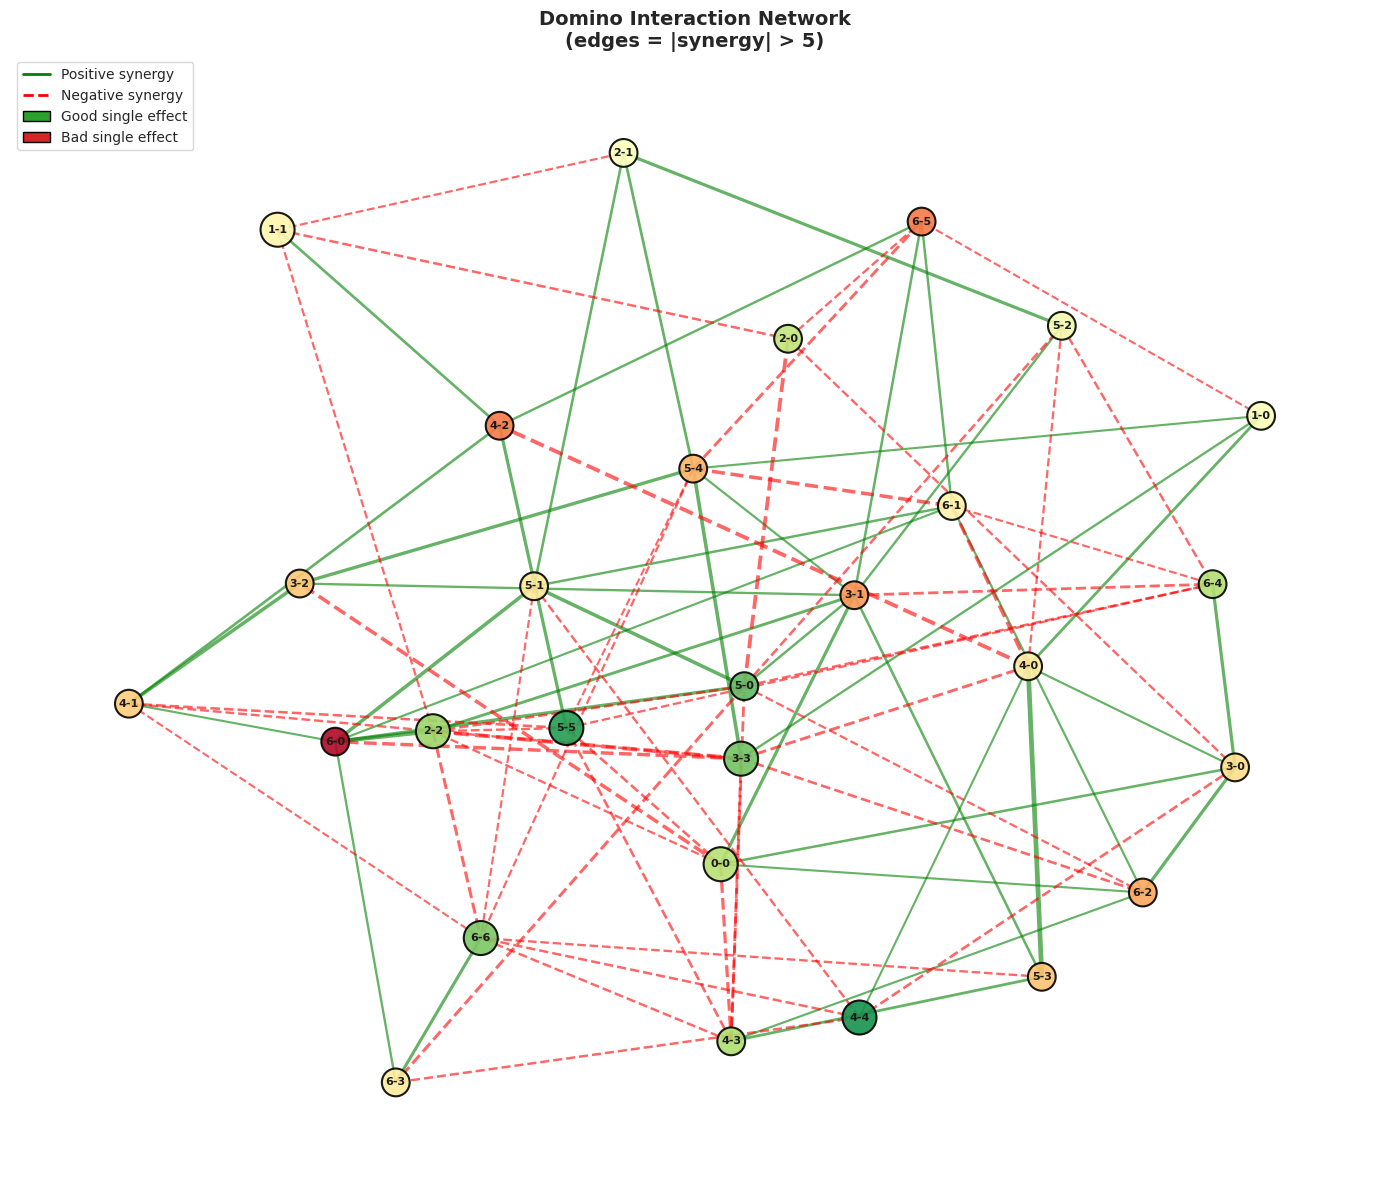

In [5]:
fig, ax = plt.subplots(figsize=(14, 12))

# Use spring layout
pos = nx.spring_layout(G, k=2.0, iterations=100, seed=42)

# Node colors based on single effect
single_effects = [G.nodes[n]['single_effect'] for n in G.nodes()]
node_colors = plt.cm.RdYlGn(np.interp(single_effects, [-10, 10], [0, 1]))

# Node sizes based on being a double
node_sizes = [600 if G.nodes[n]['is_double'] else 400 for n in G.nodes()]

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, 
                        alpha=0.9, edgecolors='black', linewidths=1.5, ax=ax)

# Draw edges with color based on synergy
edges = G.edges(data=True)
positive_edges = [(u, v) for u, v, d in edges if d['synergy'] > 0]
negative_edges = [(u, v) for u, v, d in edges if d['synergy'] < 0]

# Edge widths
pos_widths = [0.5 + 0.2 * G[u][v]['weight'] for u, v in positive_edges]
neg_widths = [0.5 + 0.2 * G[u][v]['weight'] for u, v in negative_edges]

nx.draw_networkx_edges(G, pos, edgelist=positive_edges, width=pos_widths,
                        edge_color='green', alpha=0.6, ax=ax)
nx.draw_networkx_edges(G, pos, edgelist=negative_edges, width=neg_widths,
                        edge_color='red', alpha=0.6, style='dashed', ax=ax)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold', ax=ax)

# Title and legend
ax.set_title('Domino Interaction Network\n(edges = |synergy| > 5)', fontsize=14, fontweight='bold')

# Custom legend
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [
    Line2D([0], [0], color='green', linewidth=2, label='Positive synergy'),
    Line2D([0], [0], color='red', linewidth=2, linestyle='--', label='Negative synergy'),
    Patch(facecolor='#2ca02c', edgecolor='black', label='Good single effect'),
    Patch(facecolor='#d62728', edgecolor='black', label='Bad single effect'),
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

ax.axis('off')
plt.tight_layout()
plt.savefig('../../results/figures/16d_interaction_network.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

## 4. Circular Layout by Suit

In [6]:
# Arrange dominoes by their high pip (suit)
def get_high_pip(d_id: int) -> int:
    pips = schema.domino_pips(d_id)
    return max(pips)

# Group by high pip
suit_groups = {i: [] for i in range(7)}
for d in range(28):
    suit_groups[get_high_pip(d)].append(DOMINO_NAMES[d])

# Create circular layout with suits as spokes
pos_circular = {}
for suit in range(7):
    dominoes_in_suit = suit_groups[suit]
    n = len(dominoes_in_suit)
    angle_start = suit * (2 * np.pi / 7)
    
    for i, domino in enumerate(dominoes_in_suit):
        # Spread along the spoke
        r = 0.5 + 0.4 * (i / max(n-1, 1))
        angle = angle_start + 0.1 * (i - n//2)  # Slight spread
        pos_circular[domino] = (r * np.cos(angle), r * np.sin(angle))

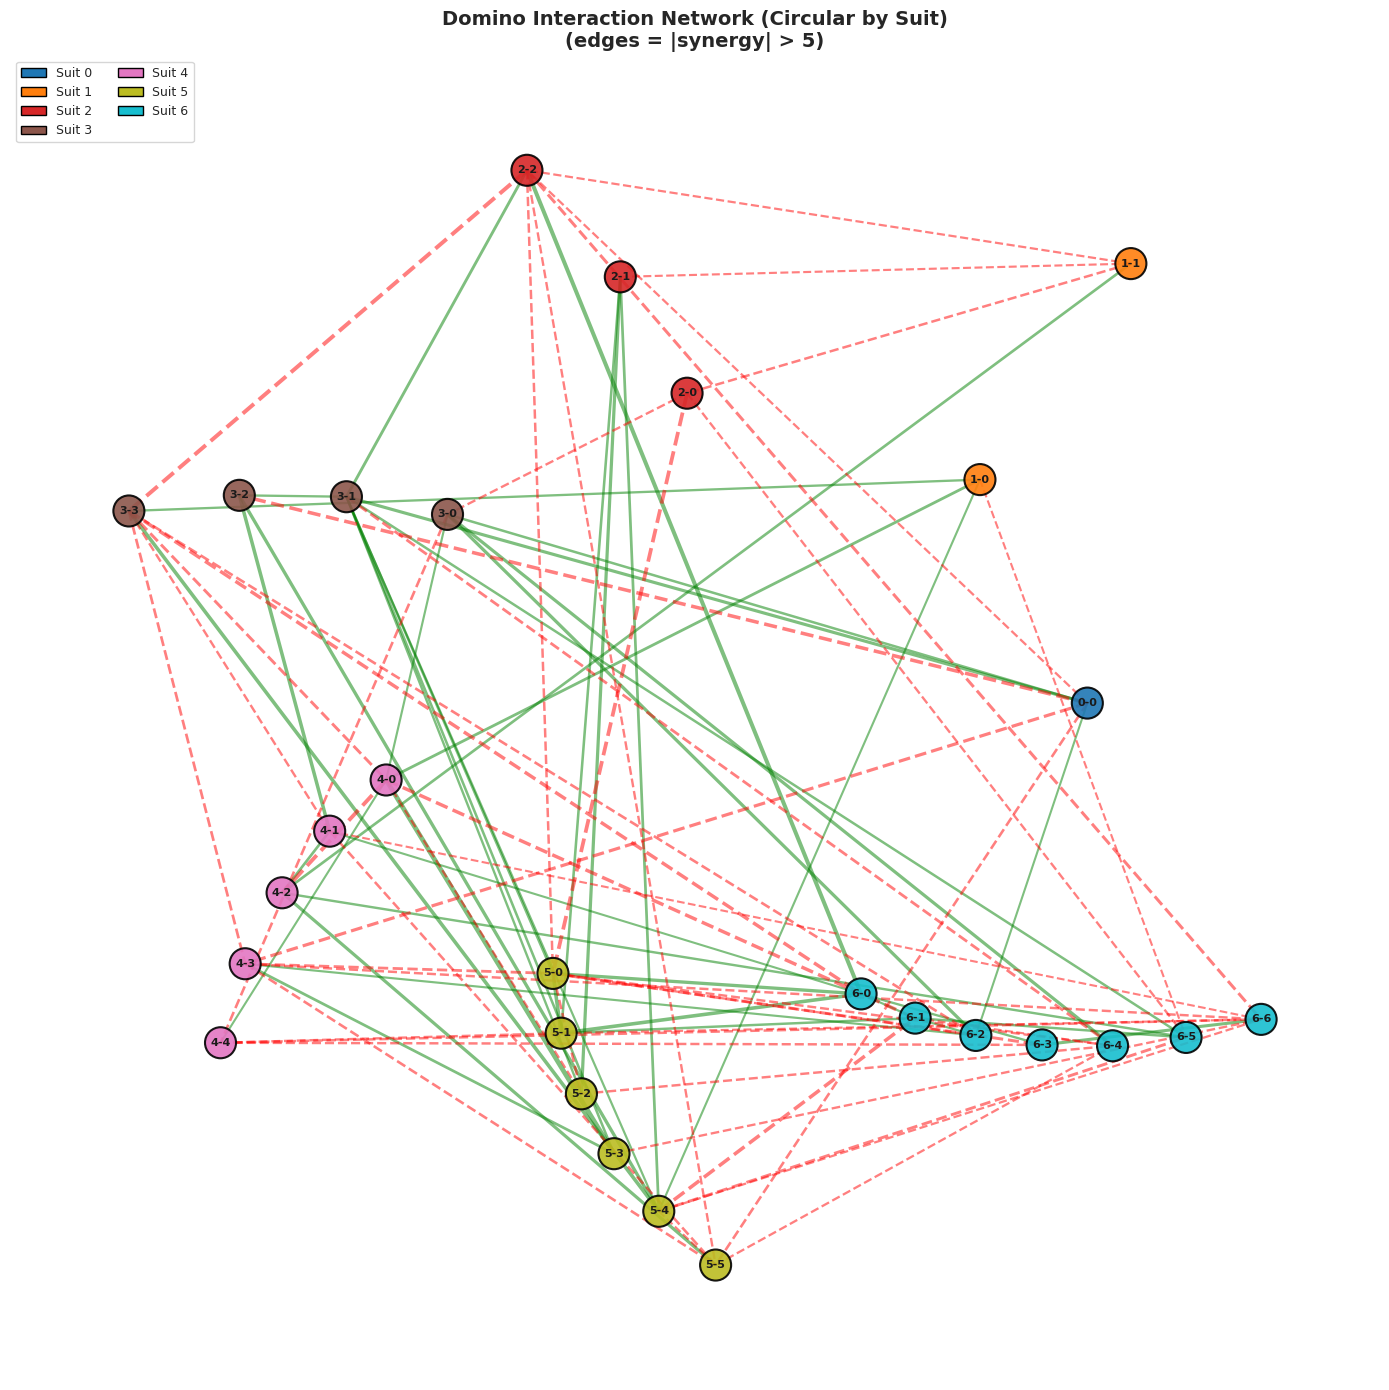

In [7]:
fig, ax = plt.subplots(figsize=(14, 14))

# Draw nodes with suit-based colors
suit_colors = plt.cm.tab10(np.linspace(0, 1, 7))
node_colors = [suit_colors[get_high_pip(G.nodes[n]['d_id'])] for n in G.nodes()]

nx.draw_networkx_nodes(G, pos_circular, node_color=node_colors, node_size=500,
                        alpha=0.9, edgecolors='black', linewidths=1.5, ax=ax)

# Draw edges
nx.draw_networkx_edges(G, pos_circular, edgelist=positive_edges, width=pos_widths,
                        edge_color='green', alpha=0.5, ax=ax)
nx.draw_networkx_edges(G, pos_circular, edgelist=negative_edges, width=neg_widths,
                        edge_color='red', alpha=0.5, style='dashed', ax=ax)

nx.draw_networkx_labels(G, pos_circular, font_size=8, font_weight='bold', ax=ax)

ax.set_title('Domino Interaction Network (Circular by Suit)\n(edges = |synergy| > 5)', 
             fontsize=14, fontweight='bold')

# Suit legend
suit_patches = [Patch(facecolor=suit_colors[i], edgecolor='black', label=f'Suit {i}') 
                for i in range(7)]
ax.legend(handles=suit_patches, loc='upper left', fontsize=9, ncol=2)

ax.axis('off')
plt.tight_layout()
plt.savefig('../../results/figures/16d_interaction_circular.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

## 5. Top Synergy Pairs Network

In [8]:
# Focus on top 15 positive and top 15 negative synergies
top_positive = synergy_df.nlargest(15, 'synergy')
top_negative = synergy_df.nsmallest(15, 'synergy')

# Build focused graph
G_focused = nx.Graph()

# Add nodes and edges for top pairs
for _, row in pd.concat([top_positive, top_negative]).iterrows():
    d1_name = DOMINO_NAMES[int(row['d1'])]
    d2_name = DOMINO_NAMES[int(row['d2'])]
    synergy = row['synergy']
    
    d1_id = int(row['d1'])
    d2_id = int(row['d2'])
    
    G_focused.add_node(d1_name, d_id=d1_id, is_double=is_double(d1_id))
    G_focused.add_node(d2_name, d_id=d2_id, is_double=is_double(d2_id))
    G_focused.add_edge(d1_name, d2_name, synergy=synergy, weight=abs(synergy))

print(f"Focused graph: {G_focused.number_of_nodes()} nodes, {G_focused.number_of_edges()} edges")

Focused graph: 25 nodes, 30 edges


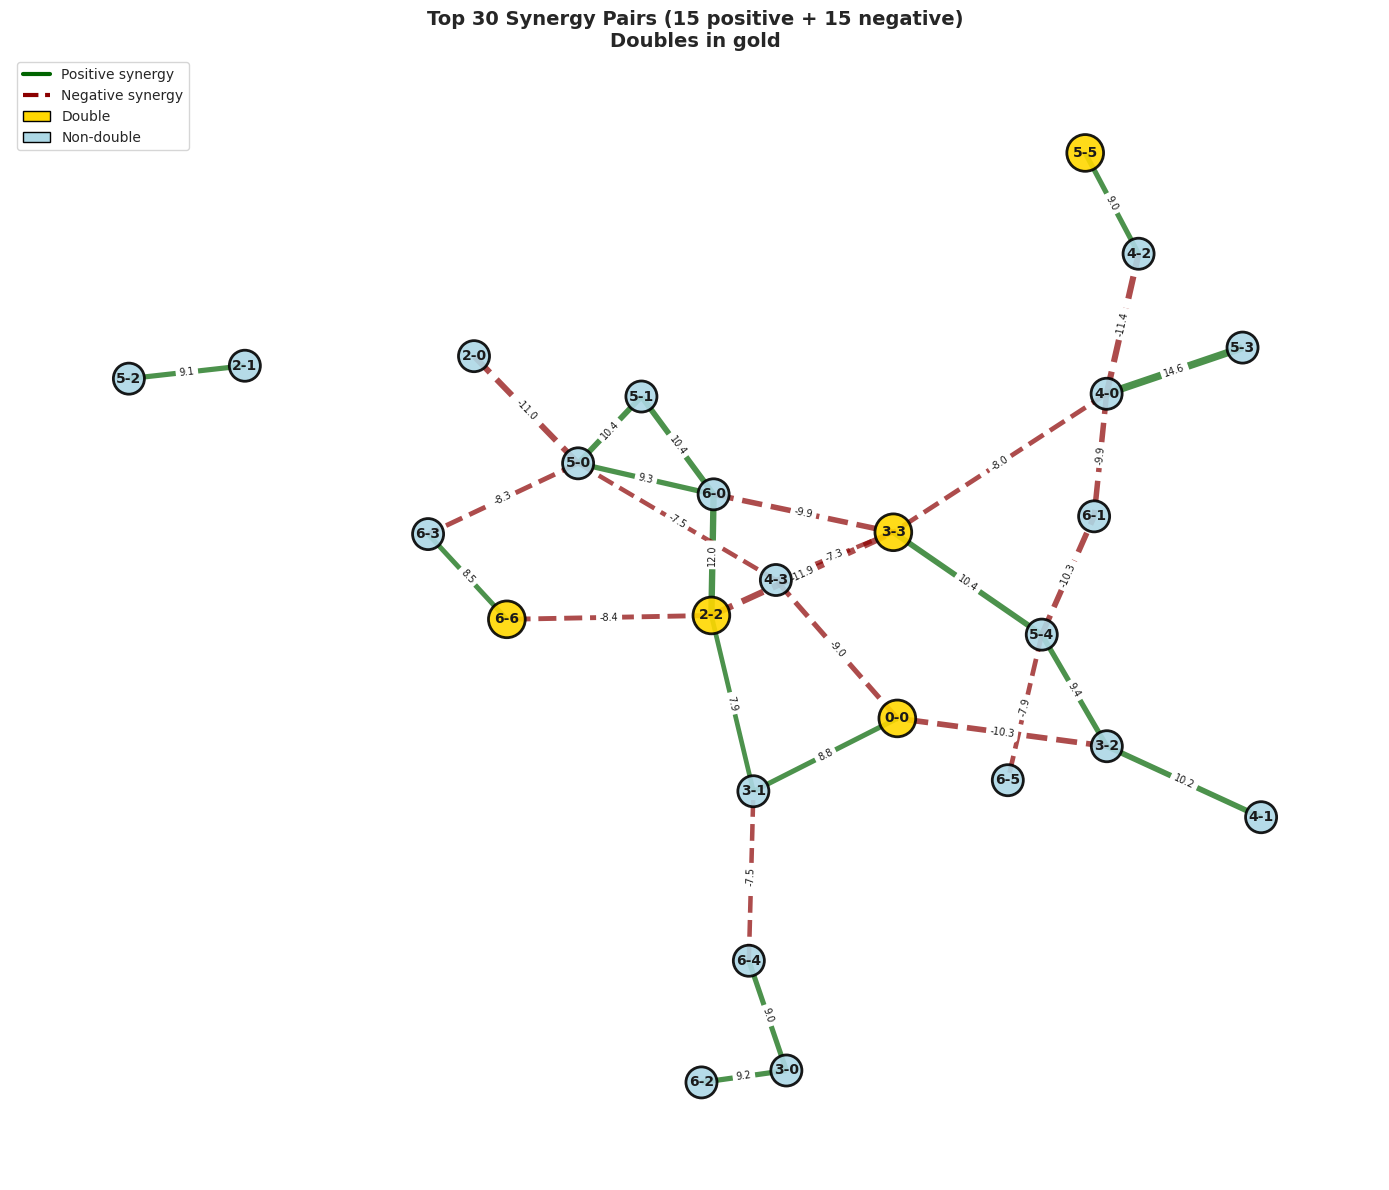

In [9]:
fig, ax = plt.subplots(figsize=(14, 12))

pos_focused = nx.spring_layout(G_focused, k=1.5, iterations=100, seed=42)

# Node styling
node_sizes = [700 if G_focused.nodes[n]['is_double'] else 500 for n in G_focused.nodes()]
node_colors = ['gold' if G_focused.nodes[n]['is_double'] else 'lightblue' for n in G_focused.nodes()]

nx.draw_networkx_nodes(G_focused, pos_focused, node_color=node_colors, node_size=node_sizes,
                        alpha=0.9, edgecolors='black', linewidths=2, ax=ax)

# Draw edges with synergy values
edges_focused = G_focused.edges(data=True)
pos_edges = [(u, v) for u, v, d in edges_focused if d['synergy'] > 0]
neg_edges = [(u, v) for u, v, d in edges_focused if d['synergy'] < 0]

pos_w = [1 + 0.3 * G_focused[u][v]['weight'] for u, v in pos_edges]
neg_w = [1 + 0.3 * G_focused[u][v]['weight'] for u, v in neg_edges]

nx.draw_networkx_edges(G_focused, pos_focused, edgelist=pos_edges, width=pos_w,
                        edge_color='darkgreen', alpha=0.7, ax=ax)
nx.draw_networkx_edges(G_focused, pos_focused, edgelist=neg_edges, width=neg_w,
                        edge_color='darkred', alpha=0.7, style='dashed', ax=ax)

# Labels
nx.draw_networkx_labels(G_focused, pos_focused, font_size=10, font_weight='bold', ax=ax)

# Edge labels (synergy values)
edge_labels = {(u, v): f"{d['synergy']:.1f}" for u, v, d in edges_focused}
nx.draw_networkx_edge_labels(G_focused, pos_focused, edge_labels, font_size=7, ax=ax)

ax.set_title('Top 30 Synergy Pairs (15 positive + 15 negative)\nDoubles in gold', 
             fontsize=14, fontweight='bold')

legend_elements = [
    Line2D([0], [0], color='darkgreen', linewidth=3, label='Positive synergy'),
    Line2D([0], [0], color='darkred', linewidth=3, linestyle='--', label='Negative synergy'),
    Patch(facecolor='gold', edgecolor='black', label='Double'),
    Patch(facecolor='lightblue', edgecolor='black', label='Non-double'),
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

ax.axis('off')
plt.tight_layout()
plt.savefig('../../results/figures/16d_top_synergies.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

## 6. Network Statistics

In [10]:
# Compute network statistics
print("Network Statistics (|synergy| > 5 threshold)")
print("=" * 50)
print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")
print(f"Density: {nx.density(G):.3f}")
print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")

if nx.is_connected(G):
    print(f"Average shortest path: {nx.average_shortest_path_length(G):.2f}")
    print(f"Diameter: {nx.diameter(G)}")
else:
    components = list(nx.connected_components(G))
    print(f"Connected components: {len(components)}")
    print(f"Largest component: {len(max(components, key=len))} nodes")

print(f"\nHighest degree nodes:")
degrees = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:5]
for node, deg in degrees:
    print(f"  {node}: {deg} connections")

Network Statistics (|synergy| > 5 threshold)
Nodes: 28
Edges: 87
Density: 0.230
Average degree: 6.21
Average shortest path: 1.91
Diameter: 3

Highest degree nodes:
  5-0: 10 connections
  3-1: 9 connections
  5-4: 9 connections
  2-2: 8 connections
  3-3: 8 connections


## Key Findings

### Network Structure

The interaction network reveals:
1. **Sparse connectivity**: Most domino pairs have near-zero synergy (additive model works)
2. **Hub dominoes**: 6-0 appears in many extreme synergies (both positive and negative)
3. **No suit clustering**: Synergies don't follow suit membership

### Interpretation

- Green edges: Pairs that work better together than expected
- Red dashed edges: Pairs that work worse together than expected
- Node color: Single-domino effect on E[V] (green = good, red = bad)

### Output Files

- `results/figures/16d_interaction_network.png` - Spring layout
- `results/figures/16d_interaction_circular.png` - Suit-organized circular layout
- `results/figures/16d_top_synergies.png` - Top 30 synergy pairs